# ARIMA #

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
from pmdarima import ARIMA

parquet_directory = '/Users/fionachow/Documents/NYU/CDS/Fall 2024/DS - GA 1018 Probabilistic Time Series/Project/electricity_demand_forecasting/data/'
metadata_file = f'{parquet_directory}/metadata.parquet'
demand_file = f'{parquet_directory}/demand.parquet'

metadata = pd.read_parquet(metadata_file)
demand = pd.read_parquet(demand_file)

**Time periods of each time series**

In [2]:
london_data_ids = metadata[metadata['dataset'] == "London Smart Meter Data"]['unique_id'].unique()
london_demand = demand[demand['unique_id'].isin(london_data_ids)]

buildingdg_data_ids = metadata[metadata['dataset'] == "Building Data Genome 2"]['unique_id'].unique()
buildingdg_demand = demand[demand['unique_id'].isin(buildingdg_data_ids)]

eld_data_ids = metadata[metadata['dataset'] == "Electricity Load Diagrams"]['unique_id'].unique()
eld_demand = demand[demand['unique_id'].isin(eld_data_ids)]

datasets = {
    "London Smart Meter Data": london_demand,
    "Building Data Genome 2": buildingdg_demand,
    "Electricity Load Diagrams": eld_demand,
}

results = {}

for name, dataset in datasets.items():
    start_date = dataset['timestamp'].min()
    end_date = dataset['timestamp'].max()
    total_days = (end_date - start_date).days
    total_years = total_days / 365
    results[name] = {
        "start_date": start_date,
        "end_date": end_date,
        "total_years": total_years,
    }

for dataset_name, metrics in results.items():
    print(f"{dataset_name}:")
    print(f"  Start Date: {metrics['start_date']}")
    print(f"  End Date: {metrics['end_date']}")
    print(f"  Total Years: {metrics['total_years']:.2f}\n")


London Smart Meter Data:
  Start Date: 2011-11-23 09:00:00
  End Date: 2014-02-28 00:00:00
  Total Years: 2.27

Building Data Genome 2:
  Start Date: 2016-01-01 00:00:00
  End Date: 2017-12-31 23:00:00
  Total Years: 2.00

Electricity Load Diagrams:
  Start Date: 2011-01-01 00:30:00
  End Date: 2015-01-01 00:00:00
  Total Years: 4.00



In [3]:
print(f"london_demand shape: {london_demand.shape}")

london_demand shape: (168323651, 3)


In [4]:
combined_df = pd.merge(demand, metadata, on='unique_id', how='inner')

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_65184/335317850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_combined_df['date'] = london_combined_df['timestamp'].dt.date


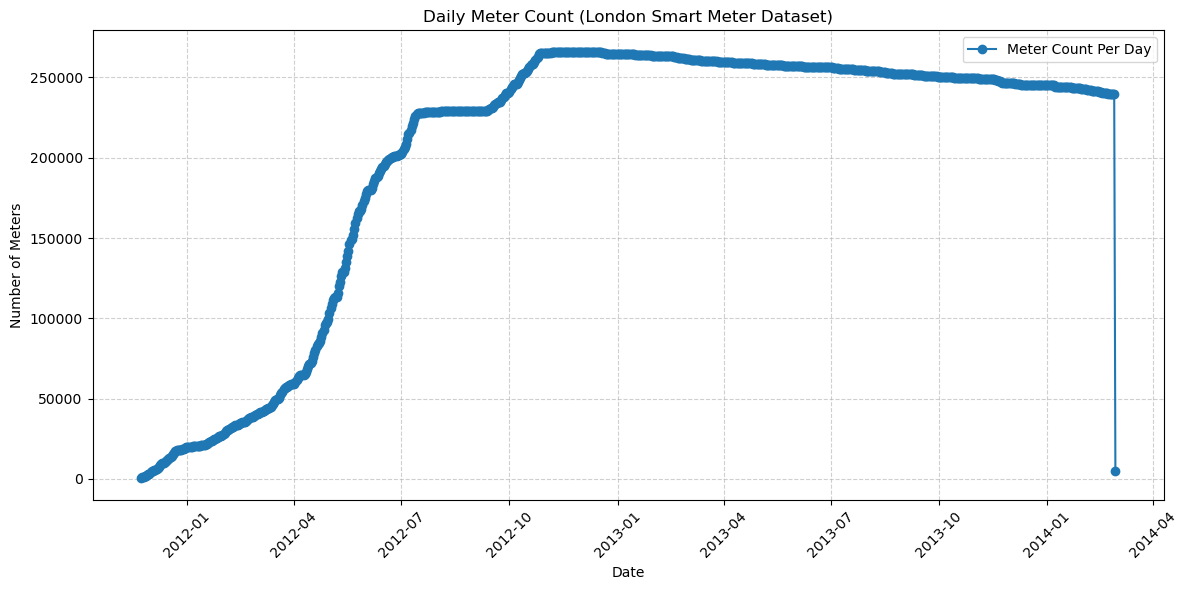

In [5]:
london_combined_df = combined_df[combined_df['dataset'] == 'London Smart Meter Data']

london_combined_df['date'] = london_combined_df['timestamp'].dt.date

daily_meter_count = london_combined_df.groupby('date')['building_id'].count().reset_index()
daily_meter_count.rename(columns={'building_id': 'meter_count'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(daily_meter_count['date'], daily_meter_count['meter_count'], marker='o', label='Meter Count Per Day')
plt.title("Daily Meter Count (London Smart Meter Dataset)")
plt.xlabel("Date")
plt.ylabel("Number of Meters")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Choosing to focus on London Smart Meter Data because it is the middle resolution of the three datasets. The data is recorded every 30 minutes.

**Data Preprocessing:** 
- Focusing on valid 30min offsets
- Train/Test Split 80/20
- Aggregating meter data by timestamp

In [17]:
london_demand['timestamp'] = pd.to_datetime(london_demand['timestamp'], errors='coerce')


valid_offsets_set = set(pd.date_range("00:00", "23:59", freq="30T").strftime("%H:%M"))
london_demand['time_offset'] = london_demand['timestamp'].dt.strftime("%H:%M")


london_demand = london_demand[london_demand['time_offset'].isin(valid_offsets_set)]
london_demand = london_demand.drop(columns=['time_offset'])

In [18]:
split_date = london_demand['timestamp'].min() + 0.8 * (london_demand['timestamp'].max() - london_demand['timestamp'].min())

train_data = london_demand[london_demand['timestamp'] < split_date]
test_data = london_demand[london_demand['timestamp'] >= split_date]

In [ ]:
aggregated_train_demand = train_data.groupby('timestamp')['y'].sum().reset_index()
aggregated_test_demand = test_data.groupby('timestamp')['y'].sum().reset_index()

**Plotting the data**

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_57886/186131851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])


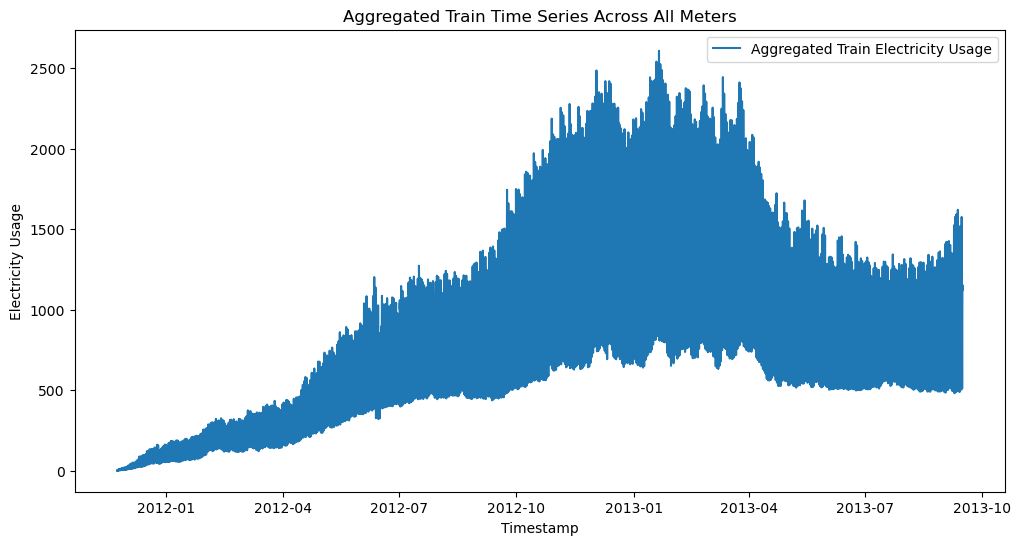

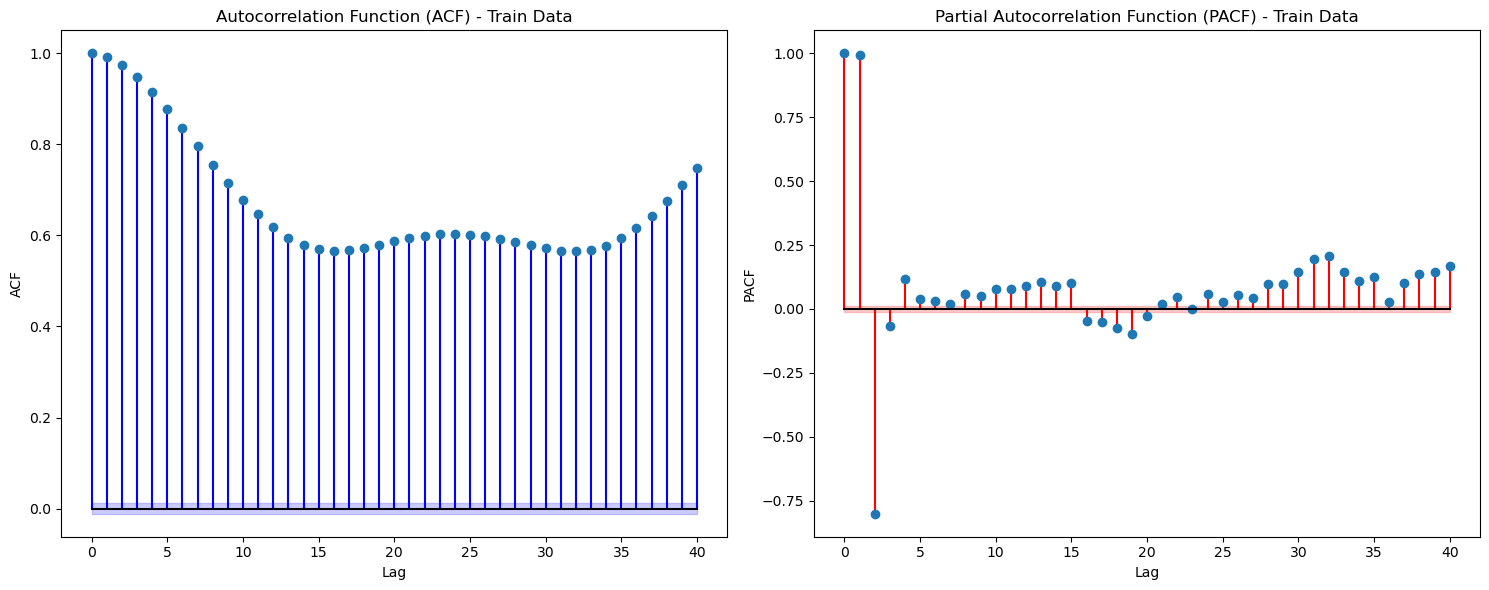

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_train_demand['timestamp'], aggregated_train_demand['y'], label='Aggregated Train Electricity Usage')
plt.title("Aggregated Train Time Series Across All Meters")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage")
plt.legend() 
plt.show()

train_signal = aggregated_train_demand['y'].to_numpy()

n_lags = 40  
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

**Differencing the data**

In [ ]:
differenced_train_signal = differenced_series['y'].to_numpy()
adf_test = adfuller(differenced_train_signal)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}") #differenced data once. Went from pvalue = 0.33 to <0.05


ADF Statistic: -44.47854972956265
p-value: 0.0


**Replotted the data after differencing the data once**

In [25]:
differenced_series = aggregated_train_demand.diff().dropna()

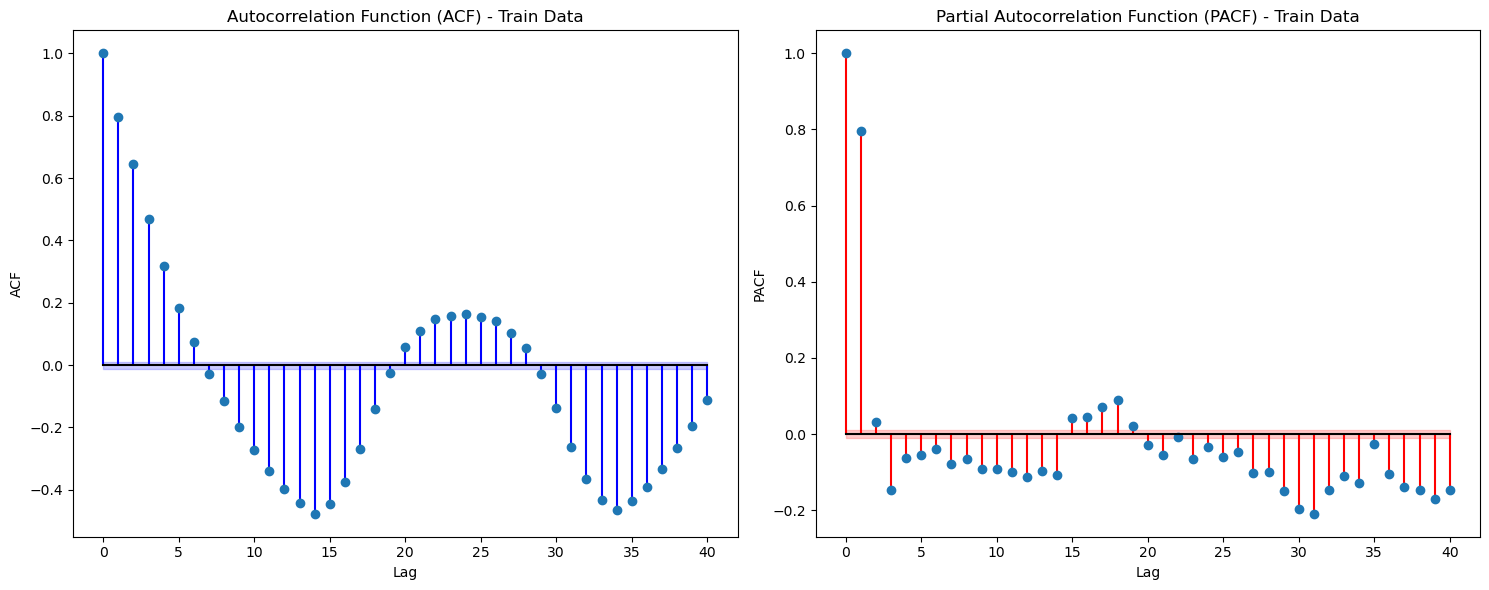

In [55]:
train_signal = differenced_series['y'].to_numpy()

n_lags = 40
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

**Modeling**
- Trying baseline model ARIMA (1,1,0) based on the above ACF/PACF plots

Fitting the ARIMA(1, 1, 0) model on the entire training dataset...
Forecasting...
Evaluation Metrics:
  MAPE: 0.4494
  RMSE: 454.0787


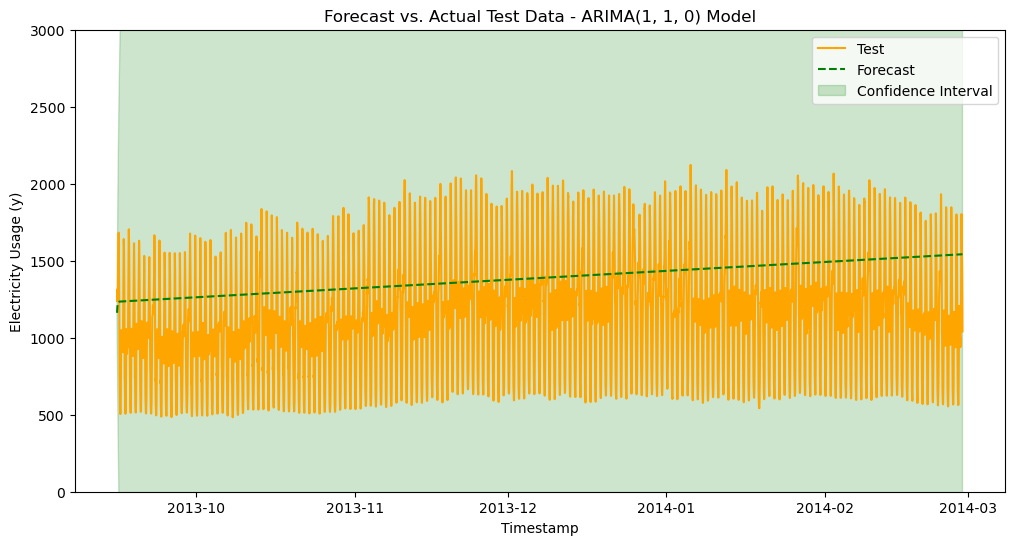

In [43]:
train_series = aggregated_train_demand.set_index('timestamp')['y']
test_series = aggregated_test_demand.set_index('timestamp')['y']

print("Fitting the ARIMA(1, 1, 0) model on the entire training dataset...")
model = ARIMA(order=(1, 1, 0), suppress_warnings=True)
model.fit(train_series)

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(1, 1, 0) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 3000) 
plt.legend()
plt.show()

Also tried to use the auto_arima function from the pmdarima library to find the best ARIMA model for the data.

Fitting ARMA model using auto_arima...
Performing stepwise search to minimize aic


/Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=352222.741, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=320252.333, Time=1.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=334559.709, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=352220.752, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=320225.265, Time=1.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=319524.342, Time=1.76 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=319401.922, Time=2.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=319308.556, Time=2.95 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=319261.724, Time=3.89 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=319066.469, Time=4.74 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=318927.538, Time=6.56 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=318655.227, Time=7.90 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=318389.678, Time=8.39 sec
 ARIMA(11,1,0)(0,0,0)[0] intercept   : AIC=318069.918, Time=9.10 sec
 ARIMA(12,1,0)(0,0,0)[0] intercept   : AIC=317

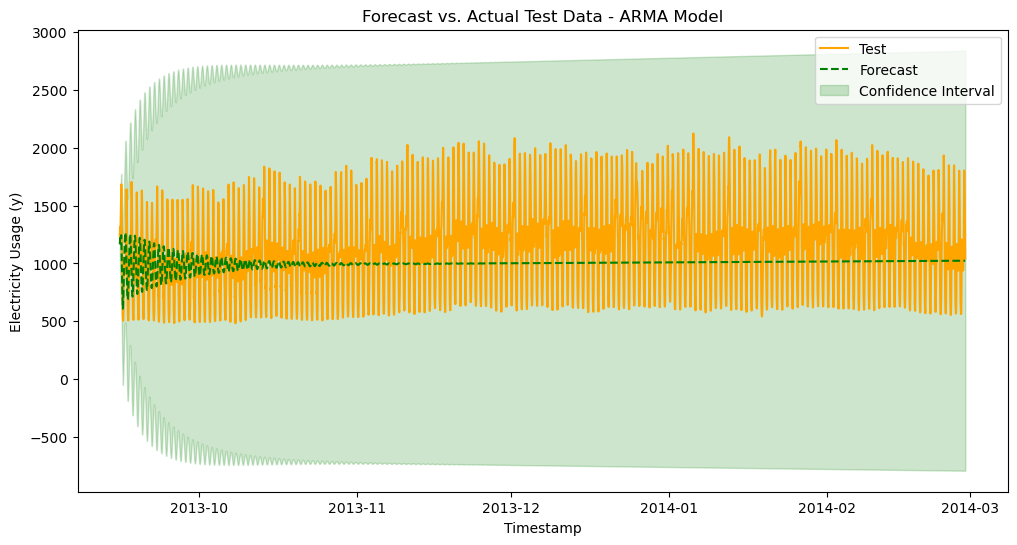

In [52]:
from pmdarima import auto_arima

print("Fitting ARMA model using auto_arima...")
arma_model = auto_arima(
    train_series,
    start_p=0, max_p=20,  
    start_q=0, max_q=20,  
    seasonal=False,      
    stepwise=True,       
    d = 1,
    trace=True,          
    suppress_warnings=True, 
    information_criterion='aic',  
    n_jobs=-1          
)

print(f"Best ARMA model order: {arma_model.order}")

print("Forecasting...")
forecast_values, conf_int = arma_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARMA Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()

**Exploring a 1-Day Interval for the ARIMA Model (average meter consumption)**

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_65184/2390165898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_demand['date'] = london_demand['timestamp'].dt.date


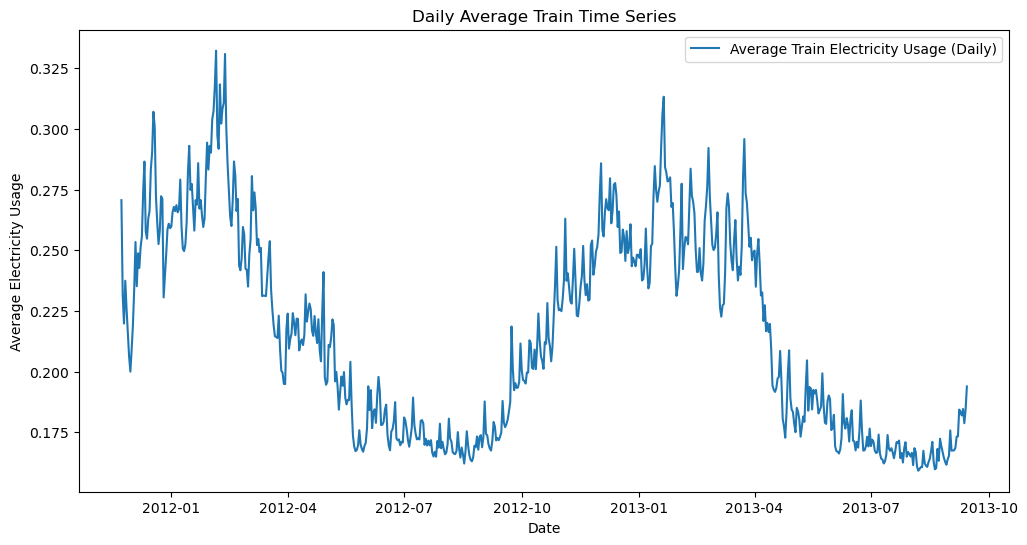

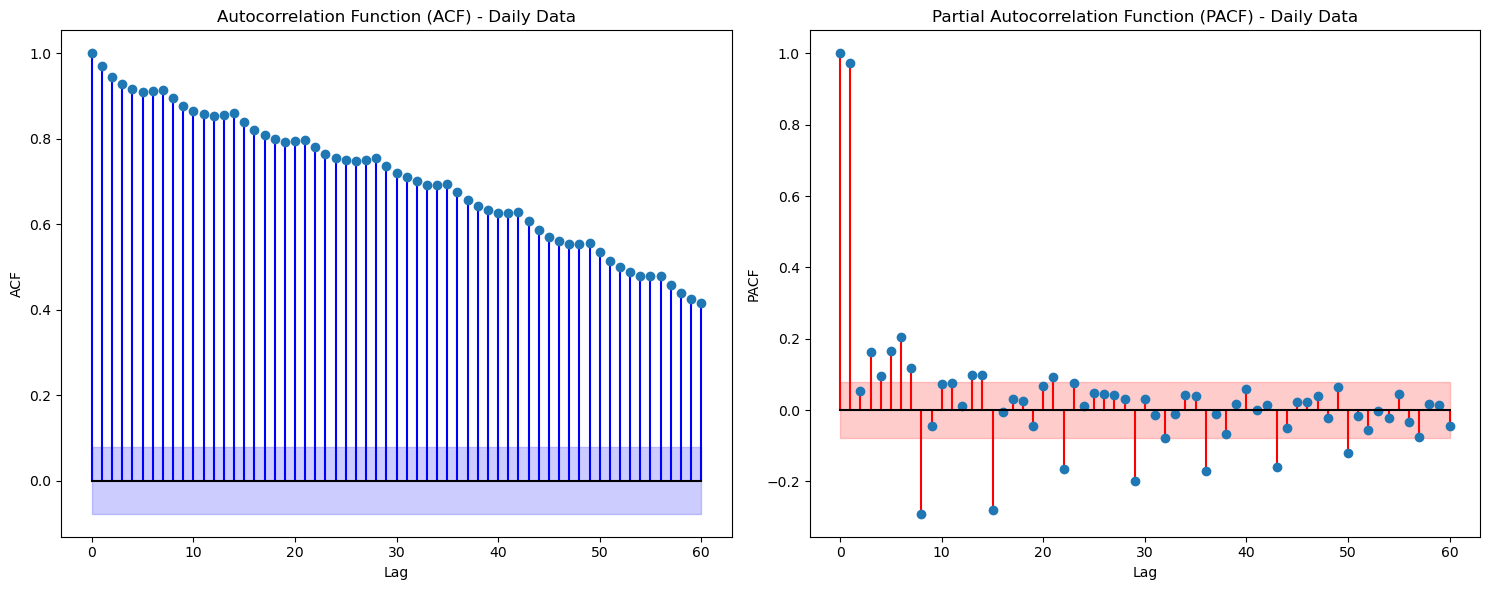

In [6]:
london_demand['date'] = london_demand['timestamp'].dt.date  

daily_demand = london_demand.groupby('date')['y'].mean().reset_index() 

split_date_daily = daily_demand['date'].min() + 0.8 * (daily_demand['date'].max() - daily_demand['date'].min())
split_date_daily = pd.to_datetime(split_date_daily).date()  

train_data_daily = daily_demand[daily_demand['date'] < split_date_daily]
test_data_daily = daily_demand[daily_demand['date'] >= split_date_daily]

plt.figure(figsize=(12, 6))
plt.plot(train_data_daily['date'], train_data_daily['y'], label='Average Train Electricity Usage (Daily)')
plt.title("Daily Average Train Time Series")
plt.xlabel("Date")
plt.ylabel("Average Electricity Usage")
plt.legend()
plt.show()

train_signal_daily = train_data_daily['y'].to_numpy()

n_lags_daily = 60 
acf_estimate_daily = acf(train_signal_daily, nlags=n_lags_daily)
pacf_estimate_daily = pacf(train_signal_daily, nlags=n_lags_daily)
acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))
pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate_daily)), acf_estimate_daily, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate_daily)), acf_error_estimate_daily, -acf_error_estimate_daily, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Daily Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate_daily)), pacf_estimate_daily, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate_daily)), pacf_error_estimate_daily, -pacf_error_estimate_daily, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Daily Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()


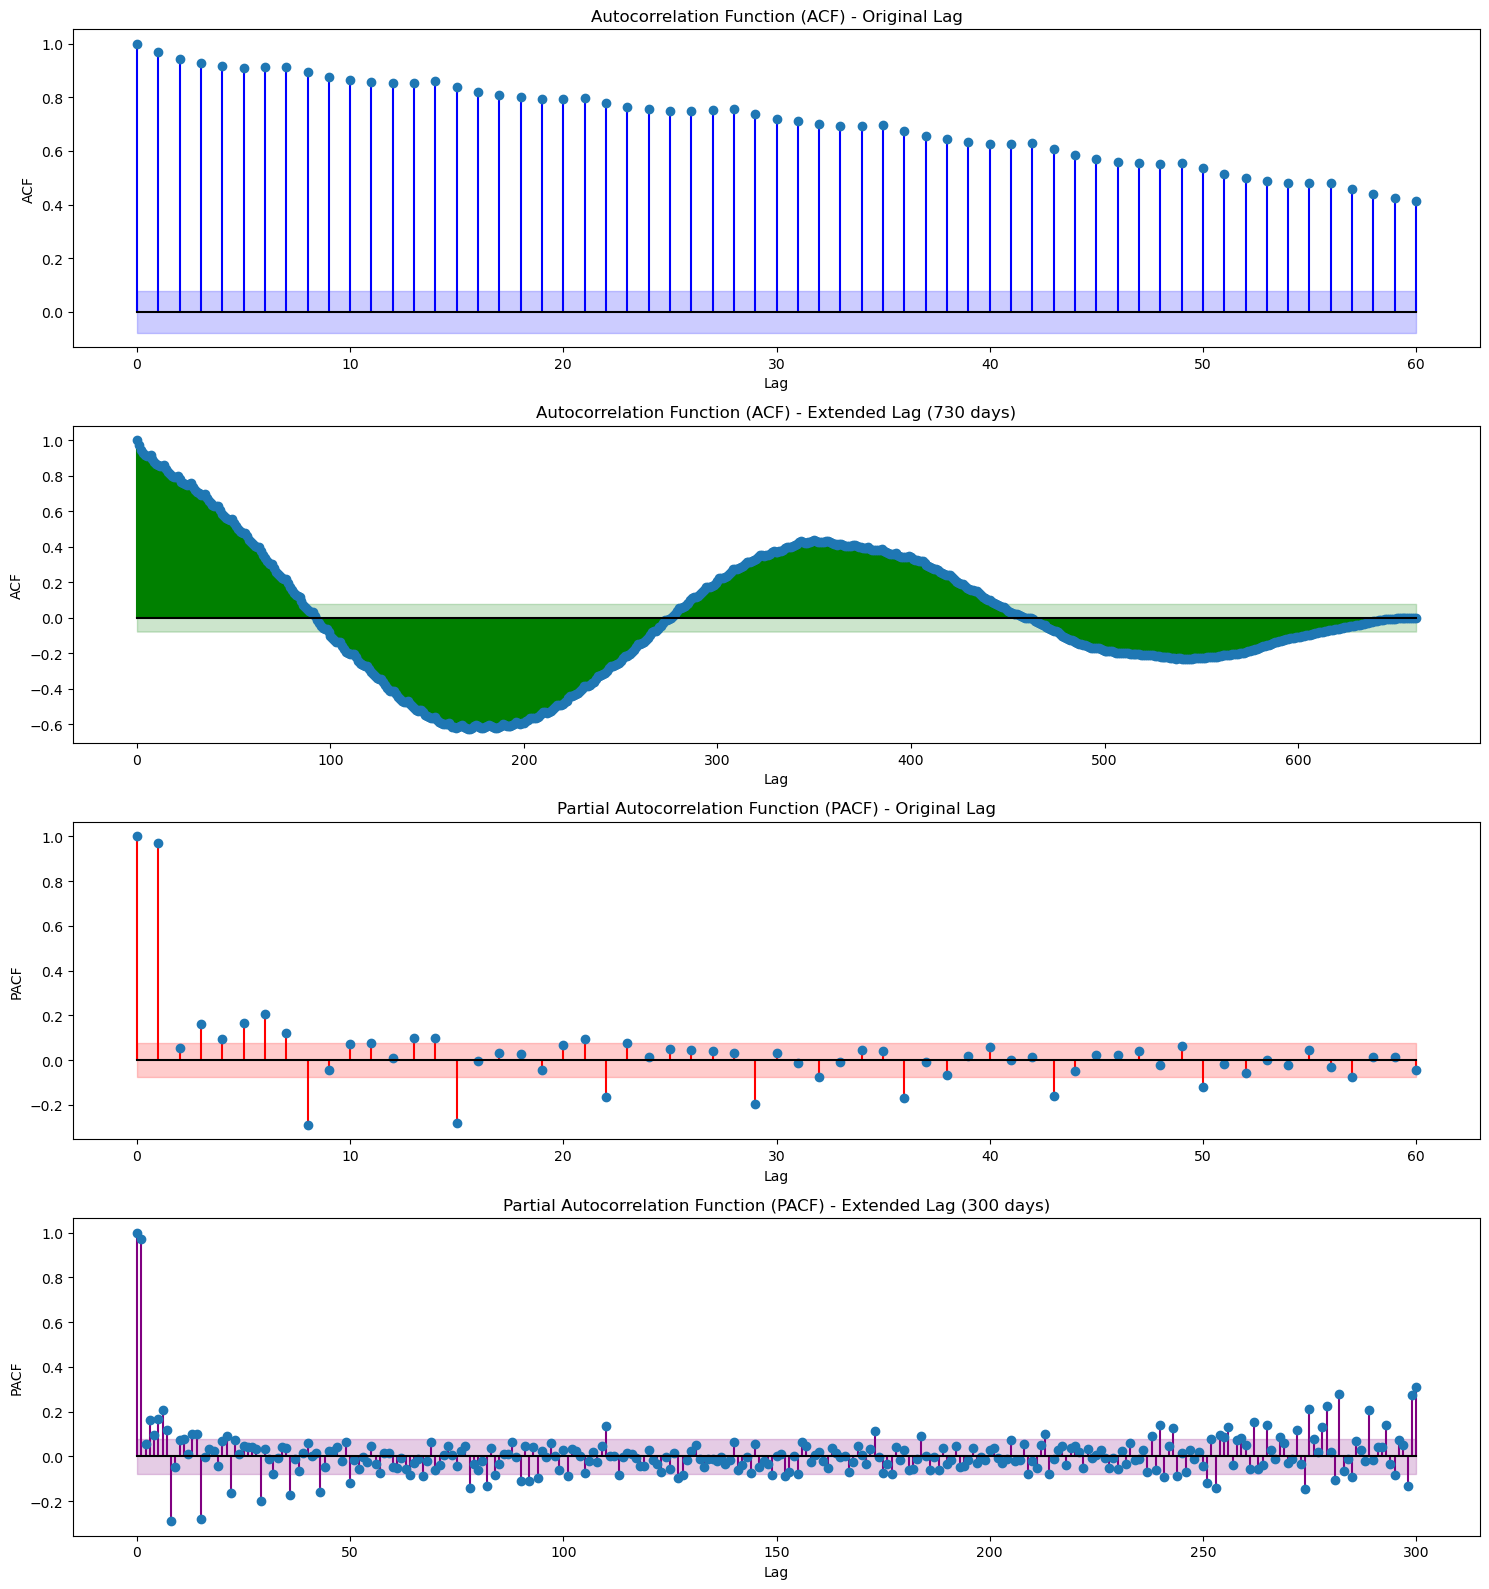

In [122]:
#extended lag to show annual seasonality
extended_n_lags = int(365 * 2)
extended_n_lags_2 = 300
extended_acf_estimate_daily = acf(train_signal_daily, nlags=extended_n_lags)
extended_acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

extended_pacf_estimate_daily = pacf(train_signal_daily, nlags=extended_n_lags_2)
extended_pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, axes = plt.subplots(4, 1, figsize=(15, 16))

axes[0].stem(range(len(acf_estimate_daily)), acf_estimate_daily, linefmt='b', basefmt='k', use_line_collection=True)
axes[0].fill_between(range(len(acf_estimate_daily)), acf_error_estimate_daily, -acf_error_estimate_daily, color='blue', alpha=0.2)
axes[0].set_title("Autocorrelation Function (ACF) - Original Lag")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

axes[1].stem(range(len(extended_acf_estimate_daily)), extended_acf_estimate_daily, linefmt='g', basefmt='k', use_line_collection=True)
axes[1].fill_between(range(len(extended_acf_estimate_daily)), extended_acf_error_estimate_daily, -extended_acf_error_estimate_daily, color='green', alpha=0.2)
axes[1].set_title(f"Autocorrelation Function (ACF) - Extended Lag ({extended_n_lags} days)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("ACF")

axes[2].stem(range(len(pacf_estimate_daily)), pacf_estimate_daily, linefmt='r', basefmt='k', use_line_collection=True)
axes[2].fill_between(range(len(pacf_estimate_daily)), pacf_error_estimate_daily, -pacf_error_estimate_daily, color='red', alpha=0.2)
axes[2].set_title("Partial Autocorrelation Function (PACF) - Original Lag")
axes[2].set_xlabel("Lag")
axes[2].set_ylabel("PACF")

axes[3].stem(range(len(extended_pacf_estimate_daily)), extended_pacf_estimate_daily, linefmt='purple', basefmt='k', use_line_collection=True)
axes[3].fill_between(range(len(extended_pacf_estimate_daily)), extended_pacf_error_estimate_daily, -extended_pacf_error_estimate_daily, color='purple', alpha=0.2)
axes[3].set_title(f"Partial Autocorrelation Function (PACF) - Extended Lag ({extended_n_lags_2} days)")
axes[3].set_xlabel("Lag")
axes[3].set_ylabel("PACF")

plt.tight_layout()
plt.show()

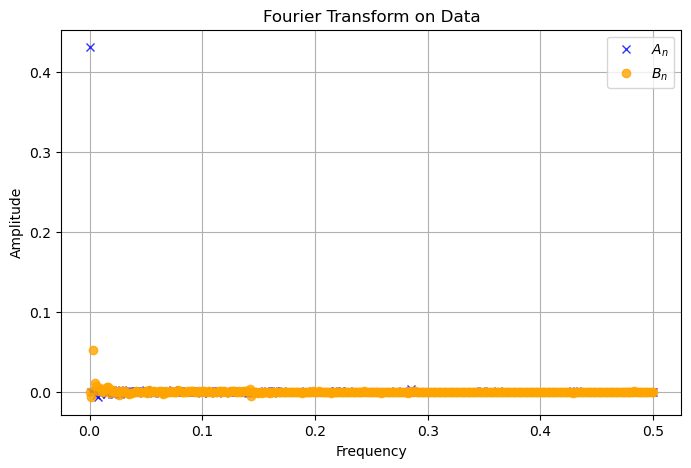

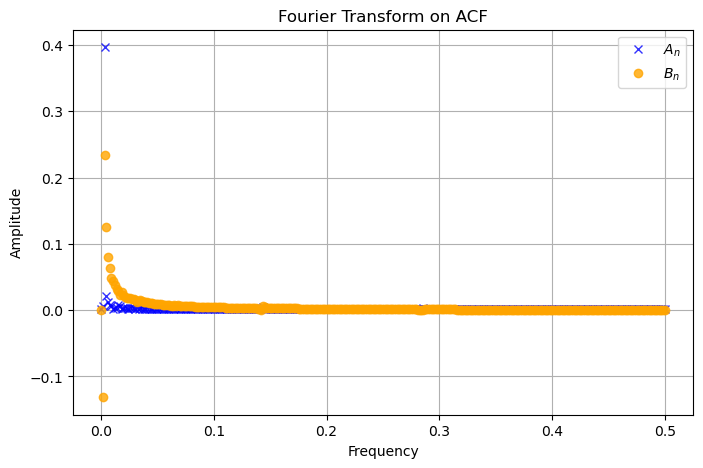

In [128]:
#FT to show seasonality
from typing import Tuple

def calculate_fourier_series(
    dt: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    frequencies = np.fft.rfftfreq(len(signal), dt)
    fourier_transform = np.fft.rfft(signal, norm='forward')
    a_n = fourier_transform.real * 2
    b_n = -fourier_transform.imag * 2
    return frequencies, a_n, b_n

def fourier_transform_plot(frequencies, a_n, b_n, title):
    plt.figure(figsize=(8, 5))
    plt.plot(frequencies, a_n, 'x', label=r'$A_n$', color='blue', alpha=0.8)
    plt.plot(frequencies, b_n, 'o', label=r'$B_n$', color='orange', alpha=0.8)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

dt = 1  

frequencies_data, a_n_data, b_n_data = calculate_fourier_series(dt, train_signal_daily)
fourier_transform_plot(frequencies_data, a_n_data, b_n_data, "Fourier Transform on Data")

acf_estimate = acf(train_signal_daily, nlags=extended_n_lags)
frequencies_acf, a_n_acf, b_n_acf = calculate_fourier_series(dt, acf_estimate)
fourier_transform_plot(frequencies_acf, a_n_acf, b_n_acf, "Fourier Transform on ACF")

In [7]:
adf_test = adfuller(train_signal_daily)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")  

ADF Statistic: -1.744059715001038
p-value: 0.40856637316149313


In [8]:
differenced_series = daily_demand.diff().dropna() #differenced data once

differenced_train_signal = differenced_series['y'].to_numpy()
adf_test = adfuller(differenced_train_signal)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}") 

ADF Statistic: -6.6753397613307275
p-value: 4.479972536543365e-09


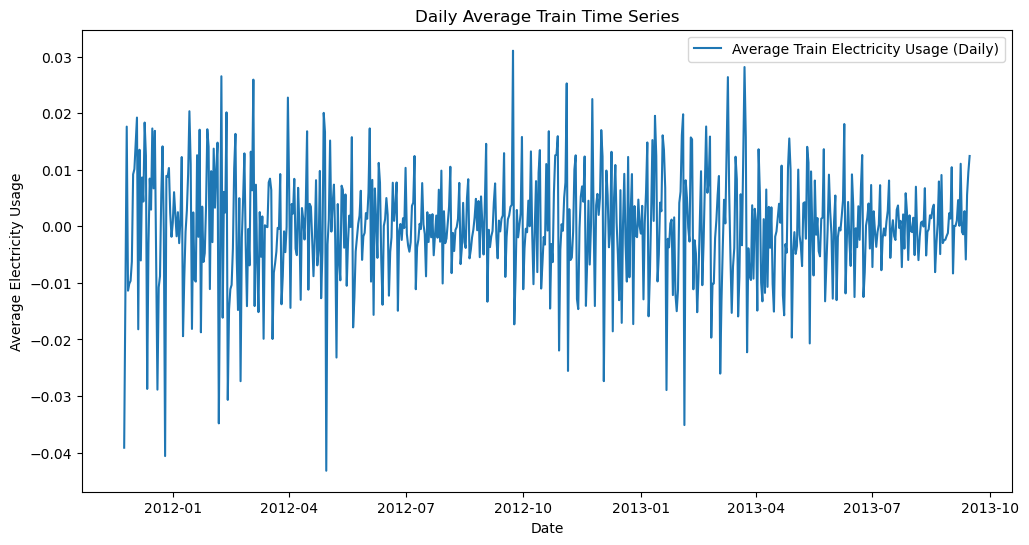

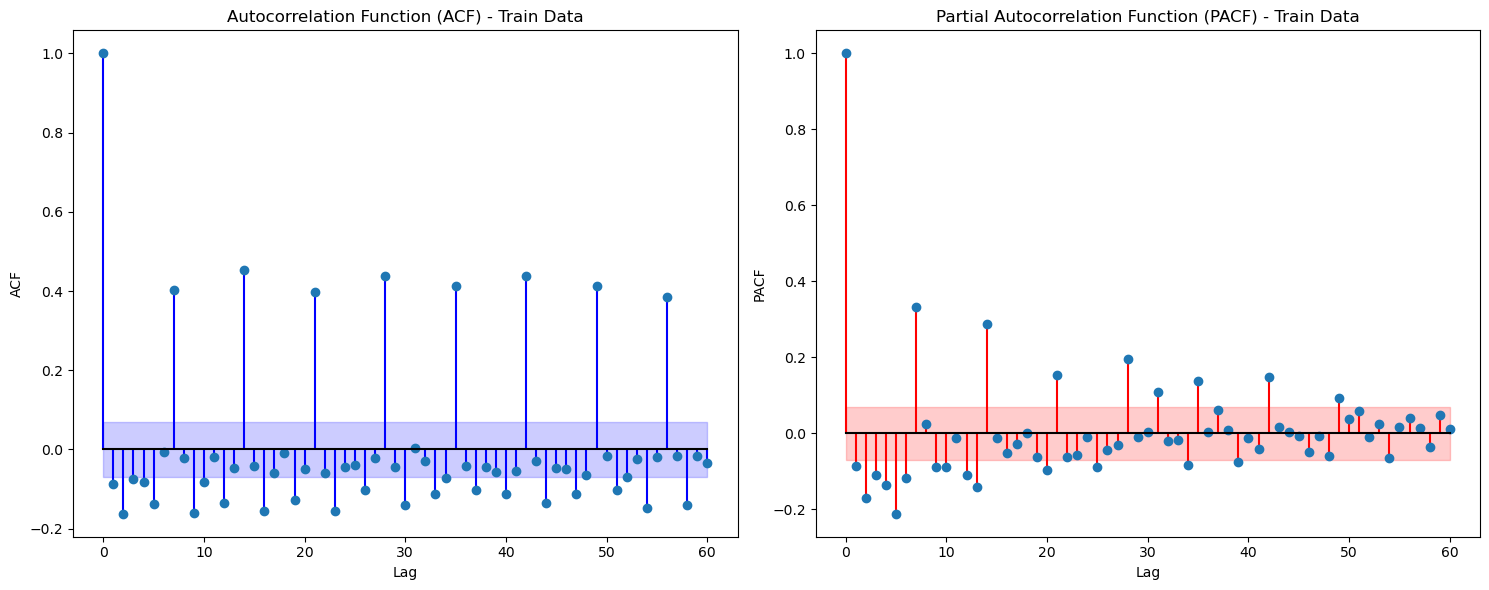

In [129]:
train_signal = differenced_series['y'].to_numpy()

# Perform differencing only on the 'y' column, not the 'date'
differenced_series = daily_demand.copy()
differenced_series['y'] = daily_demand['y'].diff().dropna() 
differenced_series = differenced_series.dropna().reset_index(drop=True) 

differenced_series['date'] = daily_demand['date'][1:].reset_index(drop=True)

differenced_series['date'] = pd.to_datetime(differenced_series['date'])

time_range = differenced_series['date'].max() - differenced_series['date'].min()
split_date_daily = differenced_series['date'].min() + pd.Timedelta(days=0.8 * time_range.days)

train_data_daily_differenced = differenced_series[differenced_series['date'] < split_date_daily]
test_data_daily_differenced = differenced_series[differenced_series['date'] >= split_date_daily]

# Plot the differenced train data
plt.figure(figsize=(12, 6))
plt.plot(train_data_daily_differenced['date'], train_data_daily_differenced['y'], label='Average Train Electricity Usage (Daily)')
plt.title("Daily Average Train Time Series")
plt.xlabel("Date")
plt.ylabel("Average Electricity Usage")
plt.legend()
plt.show()

n_lags = 60
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

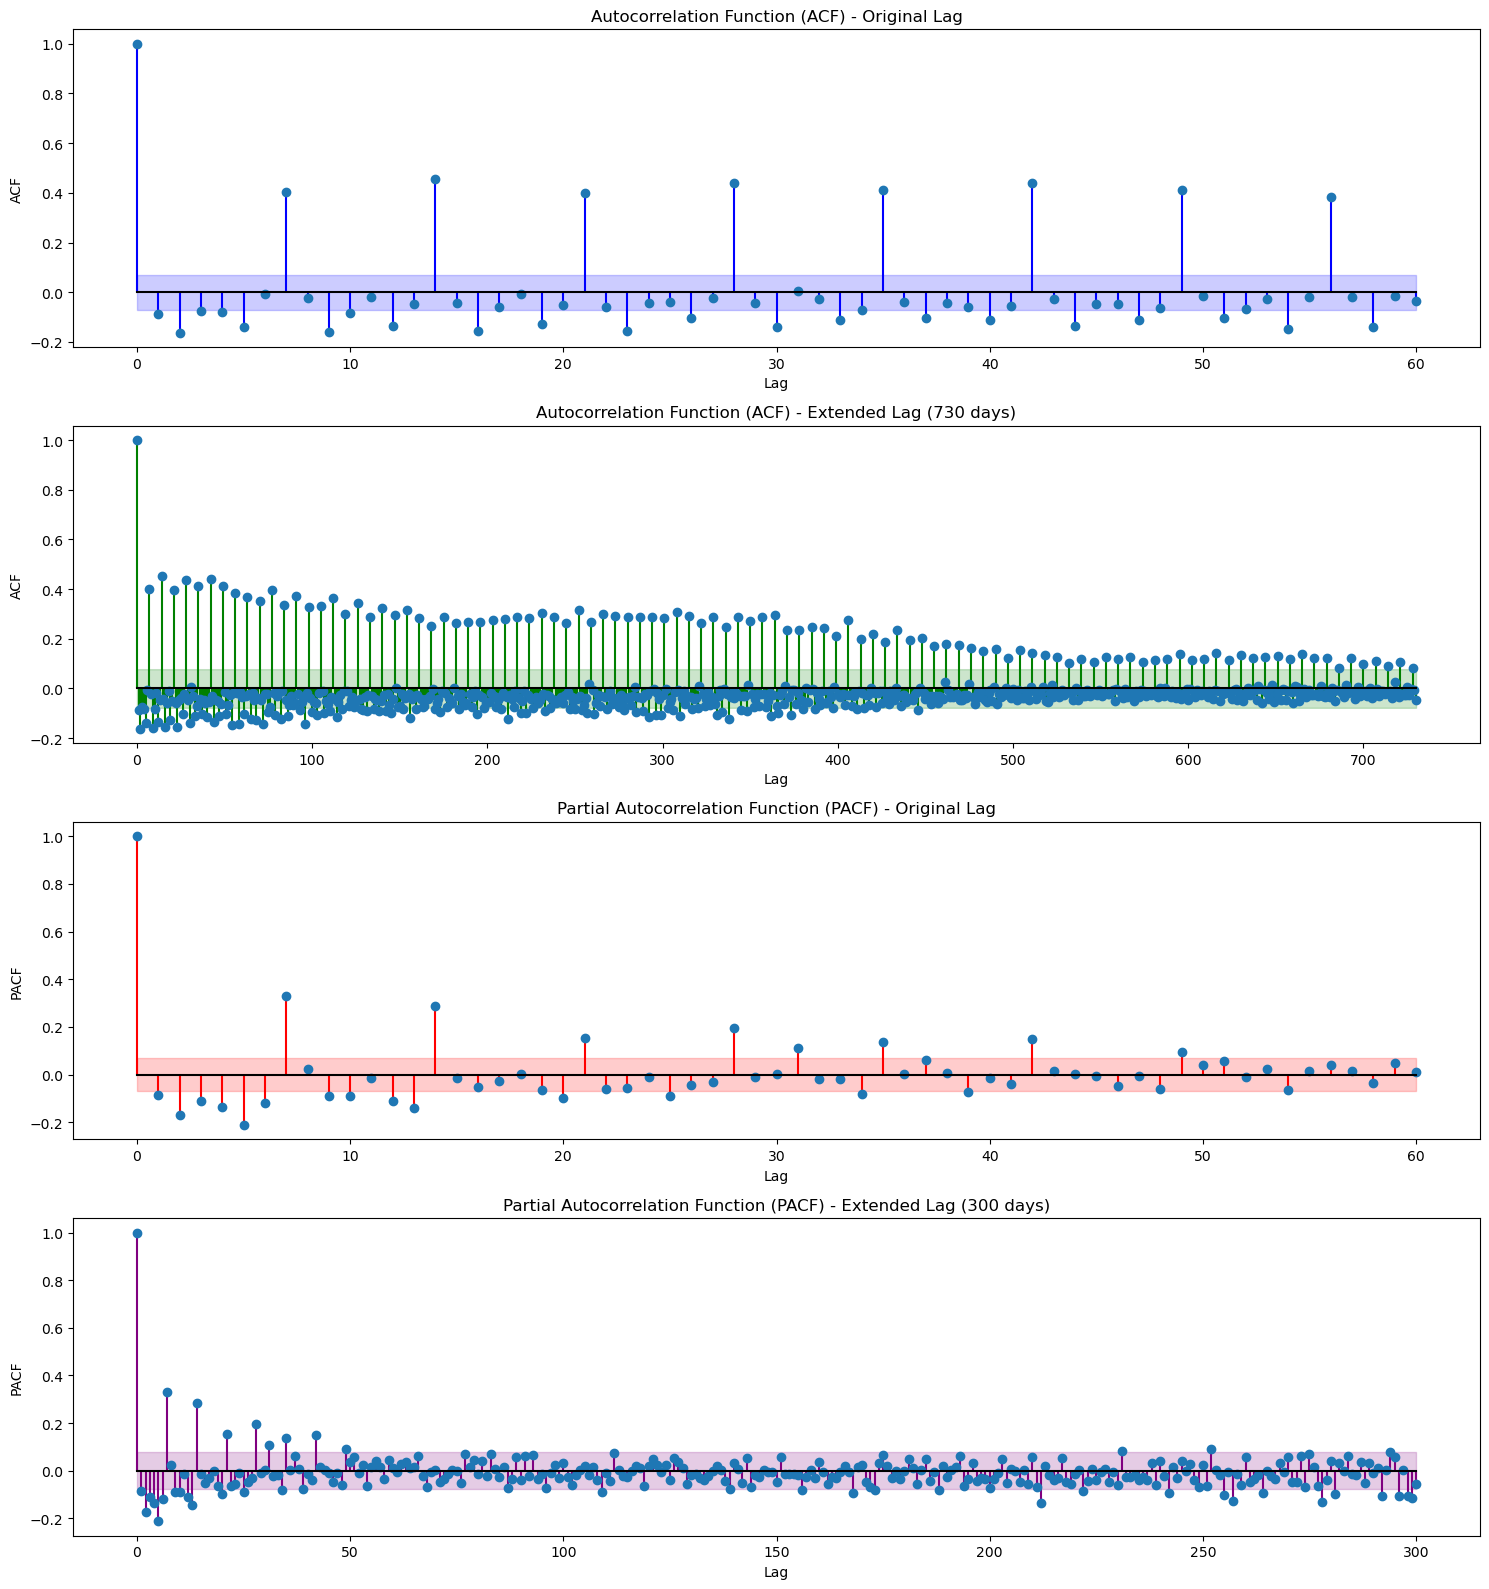

In [130]:
#extended lag to show annual seasonality
extended_n_lags = int(365 * 2)
extended_n_lags_2 = 300
extended_acf_estimate_daily = acf(train_signal, nlags=extended_n_lags)
extended_acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

extended_pacf_estimate_daily = pacf(train_signal, nlags=extended_n_lags_2)
extended_pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, axes = plt.subplots(4, 1, figsize=(15, 16))

axes[0].stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
axes[0].fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
axes[0].set_title("Autocorrelation Function (ACF) - Original Lag")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

axes[1].stem(range(len(extended_acf_estimate_daily)), extended_acf_estimate_daily, linefmt='g', basefmt='k', use_line_collection=True)
axes[1].fill_between(range(len(extended_acf_estimate_daily)), extended_acf_error_estimate_daily, -extended_acf_error_estimate_daily, color='green', alpha=0.2)
axes[1].set_title(f"Autocorrelation Function (ACF) - Extended Lag ({extended_n_lags} days)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("ACF")

axes[2].stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
axes[2].fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
axes[2].set_title("Partial Autocorrelation Function (PACF) - Original Lag")
axes[2].set_xlabel("Lag")
axes[2].set_ylabel("PACF")

axes[3].stem(range(len(extended_pacf_estimate_daily)), extended_pacf_estimate_daily, linefmt='purple', basefmt='k', use_line_collection=True)
axes[3].fill_between(range(len(extended_pacf_estimate_daily)), extended_pacf_error_estimate_daily, -extended_pacf_error_estimate_daily, color='purple', alpha=0.2)
axes[3].set_title(f"Partial Autocorrelation Function (PACF) - Extended Lag ({extended_n_lags_2} days)")
axes[3].set_xlabel("Lag")
axes[3].set_ylabel("PACF")

plt.tight_layout()
plt.show()

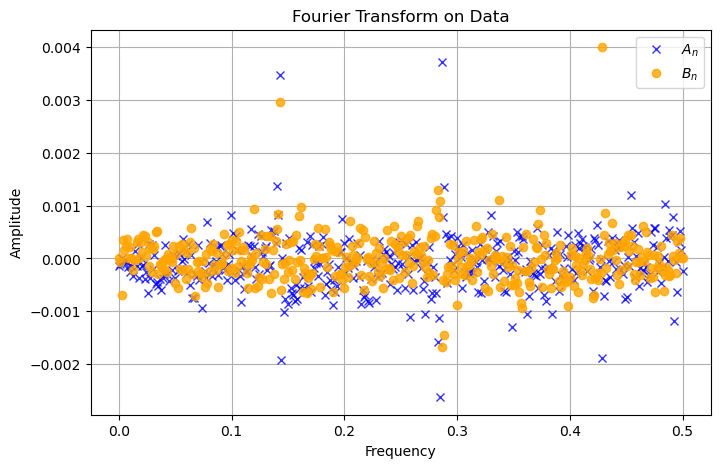

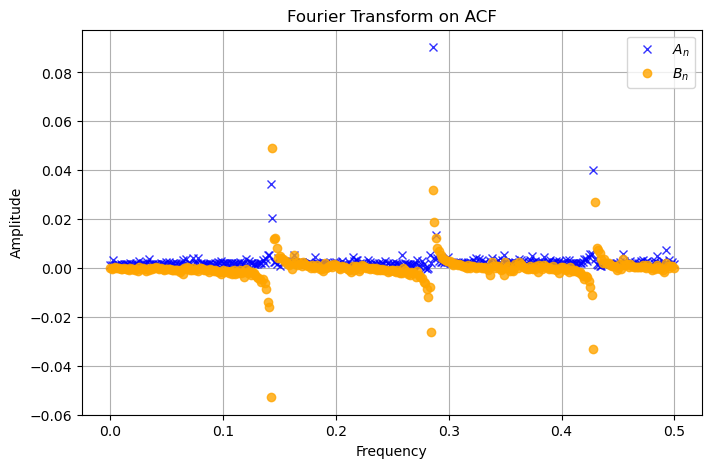

In [131]:
#FT to show seasonality
frequencies_data, a_n_data, b_n_data = calculate_fourier_series(dt, train_signal)
fourier_transform_plot(frequencies_data, a_n_data, b_n_data, "Fourier Transform on Data")

acf_estimate = acf(train_signal, nlags=extended_n_lags)
frequencies_acf, a_n_acf, b_n_acf = calculate_fourier_series(dt, acf_estimate)
fourier_transform_plot(frequencies_acf, a_n_acf, b_n_acf, "Fourier Transform on ACF")

Fitting the ARIMA(2, 0, 0) model on the entire training dataset...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  662
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2119.344
Date:                Tue, 03 Dec 2024   AIC                          -4230.688
Time:                        00:15:30   BIC                          -4212.707
Sample:                    11-23-2011   HQIC                         -4223.720
                         - 09-14-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0059      0.002      2.467      0.014       0.001       0.011
ar.L1          0.9478      0.037     25.737      0.000       0.8

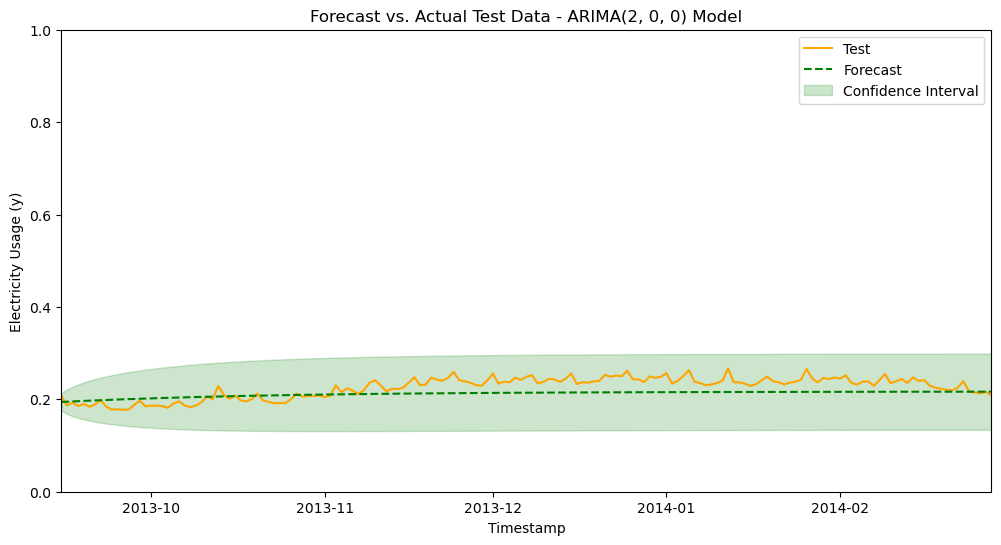

In [110]:
train_series = train_data_daily.set_index('date')['y']
test_series = test_data_daily.set_index('date')['y']

print("Fitting the ARIMA(2, 0, 0) model on the entire training dataset...")
model = ARIMA(order=(2, 0, 0), suppress_warnings=True)
model.fit(train_series)
print(model.summary())

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(2, 0, 0) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.xlim(test_series.index.min(), test_series.index.max())
plt.ylim(0, 1) 
plt.legend()
plt.show()

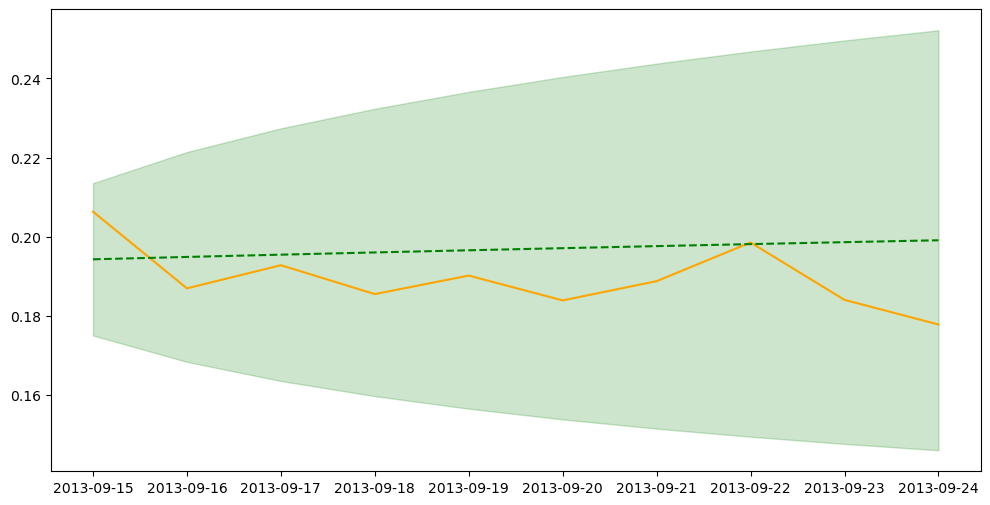

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(test_series.index[:10], test_series.iloc[:10], label='Test', color='orange')
plt.plot(test_series.index[:10], forecast_values[:10], label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index[:10], conf_int[:10, 0], conf_int[:10, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.show()

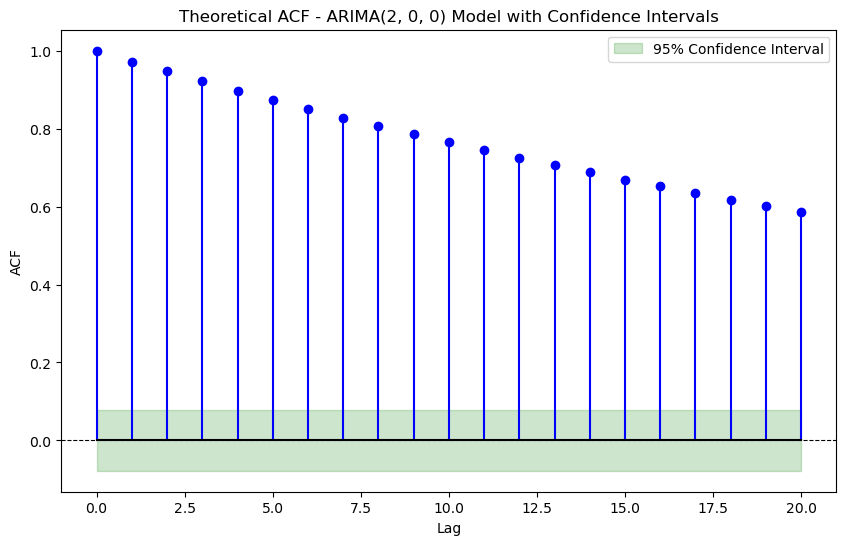

In [112]:
from statsmodels.tsa.arima_process import ArmaProcess

#theoretical ACF

ar_params = model.arparams()  
ma_params = model.maparams()   

arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])

n_lags = 20  
theoretical_acf = arma_process.acf(lags=n_lags + 1)

n_samples = len(train_series)  
conf_interval = 2 / np.sqrt(n_samples)  

plt.figure(figsize=(10, 6))
plt.stem(range(n_lags + 1), theoretical_acf, linefmt='b-', basefmt='k', markerfmt='bo', use_line_collection=True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(
    range(n_lags + 1), 
    -conf_interval, 
    conf_interval, 
    color='green', alpha=0.2, label="95% Confidence Interval"
)
plt.title("Theoretical ACF - ARIMA(2, 0, 0) Model with Confidence Intervals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()


Fitting ARMA model using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4221.387, Time=0.19 sec


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4220.375, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4220.871, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4223.296, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4251.765, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4261.547, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4236.683, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4241.349, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4253.056, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4166.417, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4242.304, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4249.523, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4263.882, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4240.960, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4238.534, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4243.207, Time=0.11

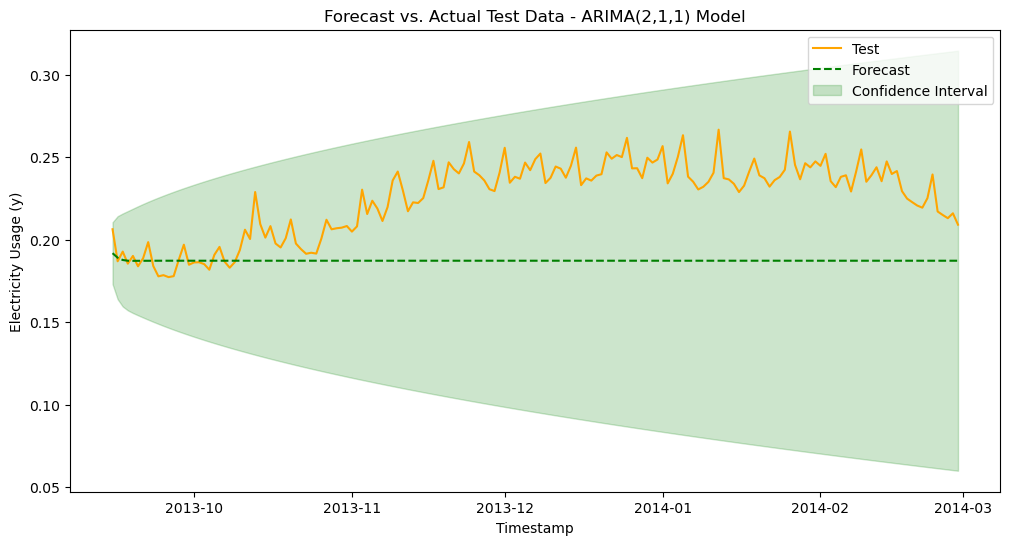

In [113]:
from pmdarima import auto_arima

print("Fitting ARMA model using auto_arima...")
arma_model = auto_arima(
    train_series,
    start_p=0, max_p=3,  
    start_q=0, max_q=3,  
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    suppress_warnings=True, 
    information_criterion='aic',  
    n_jobs=-1          
)

print(f"Best ARMA model order: {arma_model.order}")
print(arma_model.summary())

print("Forecasting...")
forecast_values, conf_int = arma_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(2,1,1) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()

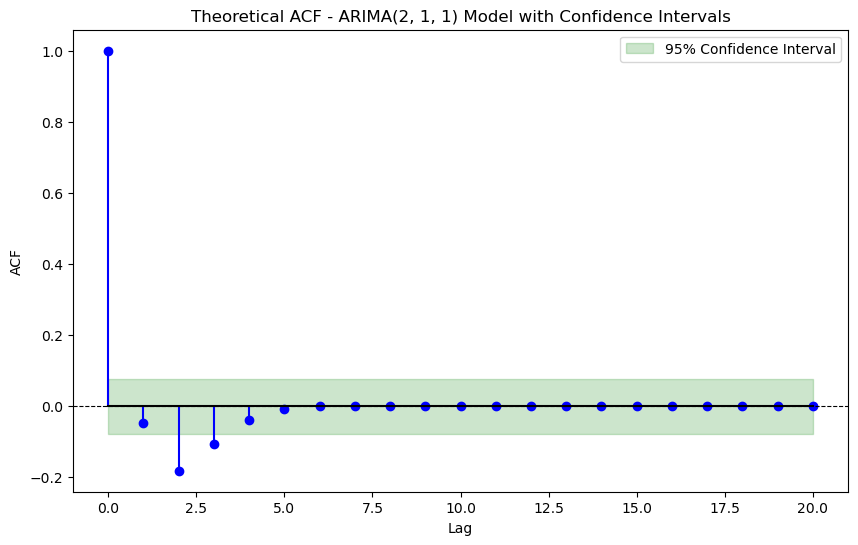

In [114]:
#theoretical ACF
ar_params = arma_model.arparams()  
ma_params = arma_model.maparams()   

arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])

n_lags = 20  
theoretical_acf = arma_process.acf(lags=n_lags + 1)

n_samples = len(train_series)  
conf_interval = 2 / np.sqrt(n_samples)  

plt.figure(figsize=(10, 6))
plt.stem(range(n_lags + 1), theoretical_acf, linefmt='b-', basefmt='k', markerfmt='bo', use_line_collection=True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(
    range(n_lags + 1), 
    -conf_interval, 
    conf_interval, 
    color='green', alpha=0.2, label="95% Confidence Interval"
)
plt.title("Theoretical ACF - ARIMA(2, 1, 1) Model with Confidence Intervals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()

**SARIMA**

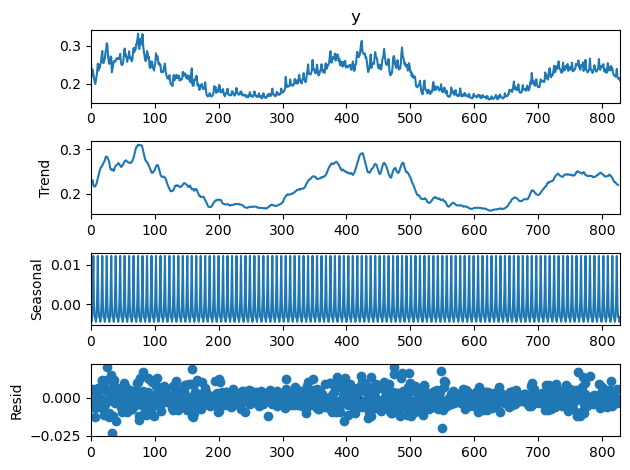

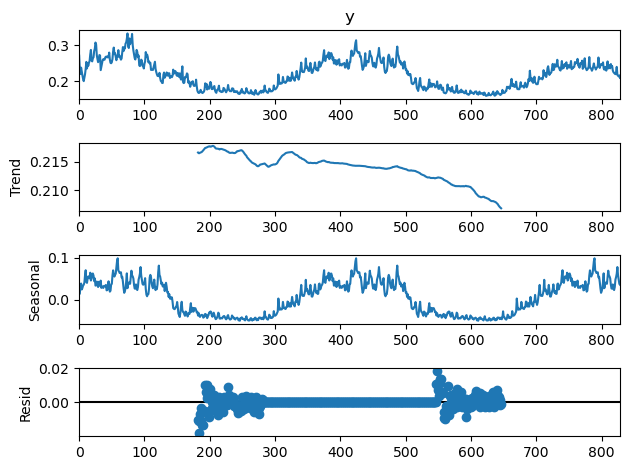

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_demand['y'], model='additive', period=7)  
decomposition.plot()
plt.show()

decomposition_yearly = seasonal_decompose(daily_demand['y'], model='additive', period=365)
decomposition_yearly.plot()
plt.show()

Fitting ARMA model using auto_arima...
Performing stepwise search to minimize aic


/Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-4221.387, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-4319.563, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-4279.147, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-4223.296, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-4220.375, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-4394.987, Time=1.44 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=-4416.549, Time=6.50 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=-4448.239, Time=5.89 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=-4461.021, Time=122.12 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=-4466.437, Time=145.22 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=-4460.279, Time=10.68 sec
 ARIMA(1,1,0)(5,0,2)[7] intercept   : AIC=-4490.085, Time=236.51 sec
 ARIMA(1,1,0)(4,0,2)[7] intercept   : AIC=-4489.236, Time=11.09 sec
 ARIMA(1,1,0)(5,0,3)[7] intercept   : AIC=-4491.637, Time=101.29 sec
 ARIMA(1,1,0)(4,0,3)[7] intercept   : AIC=-4493.416,

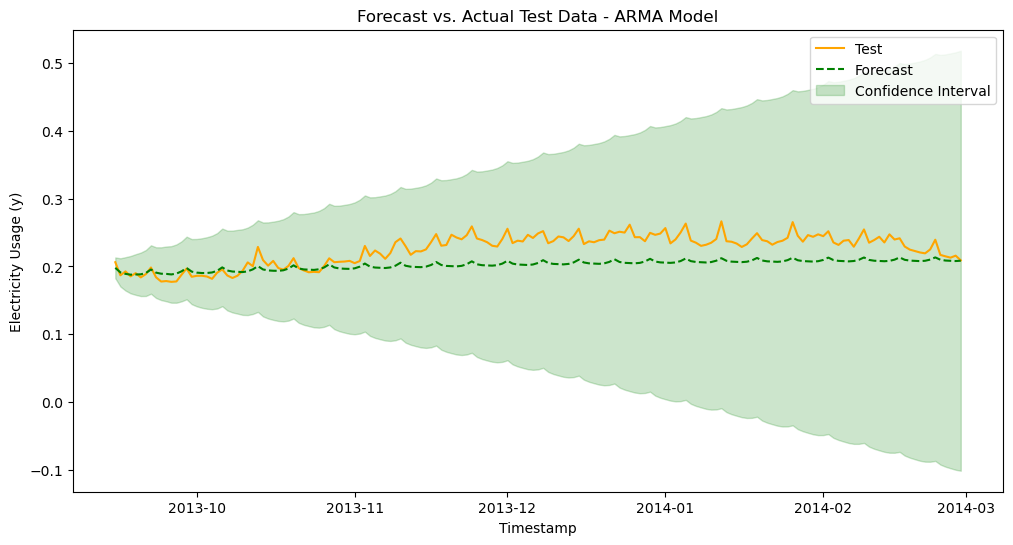

In [ ]:
print("Fitting ARMA model using auto_arima...")

sarima_model = auto_arima(
    train_series,
    start_p=0, max_p=2,             
    start_q=0, max_q=2,             
    d=None,                         
    start_P=0, max_P=5,             # Range of seasonal AR terms
    start_Q=0, max_Q=5,             # Range of seasonal MA terms
    D=None,                         # Automatically determine seasonal differencing (D)
    seasonal=True,                  # Enable seasonal SARIMA modeling
    m=7,                            # Seasonal period (e.g., 7 for weekly seasonality)
    trace=True,                     
    error_action='ignore',          
    suppress_warnings=True,        
    stepwise=True,                  
    information_criterion='aic',    
    n_jobs=-1                       
)

print(f"Best ARMA model order: {sarima_model.order}")

print("Forecasting...")
forecast_values, conf_int = sarima_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the entire training dataset...
Forecasting...
Evaluation Metrics:
  MAPE: 0.1031
  RMSE: 0.0285


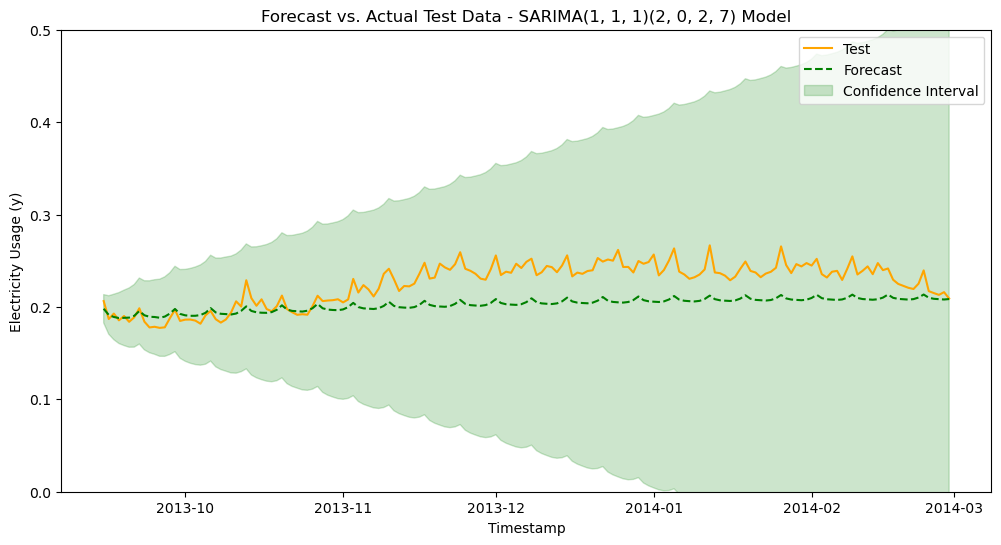

In [115]:
print("Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the entire training dataset...")
model = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 7), suppress_warnings=True)
model.fit(train_series)

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - SARIMA(1, 1, 1)(2, 0, 2, 7) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 0.5)  
plt.legend()
plt.show()


ADF Statistic: -5.78576449685279
P-Value: 5.003867832464709e-07
The series is stationary after differencing.
Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the differenced dataset...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.32283D+00    |proj g|=  3.81763D+01


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 This problem is unconstrained.



At iterate    5    f= -3.36990D+00    |proj g|=  1.61841D+00

At iterate   10    f= -3.37225D+00    |proj g|=  1.89990D-01

At iterate   15    f= -3.37286D+00    |proj g|=  3.60340D+00

At iterate   20    f= -3.37568D+00    |proj g|=  2.98349D-01

At iterate   25    f= -3.37628D+00    |proj g|=  5.09506D+00

At iterate   30    f= -3.38199D+00    |proj g|=  1.57174D+00

At iterate   35    f= -3.38239D+00    |proj g|=  4.95376D-02

At iterate   40    f= -3.38258D+00    |proj g|=  1.28141D+00

At iterate   45    f= -3.38307D+00    |proj g|=  3.27773D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     77      1     0     0   1.351D-02  -3.383D+00
  F =  -3.3830737802016579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  661
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood                2236.212
Date:                                Tue, 03 Dec 2024   AIC                          -4458.424
Time:                                      

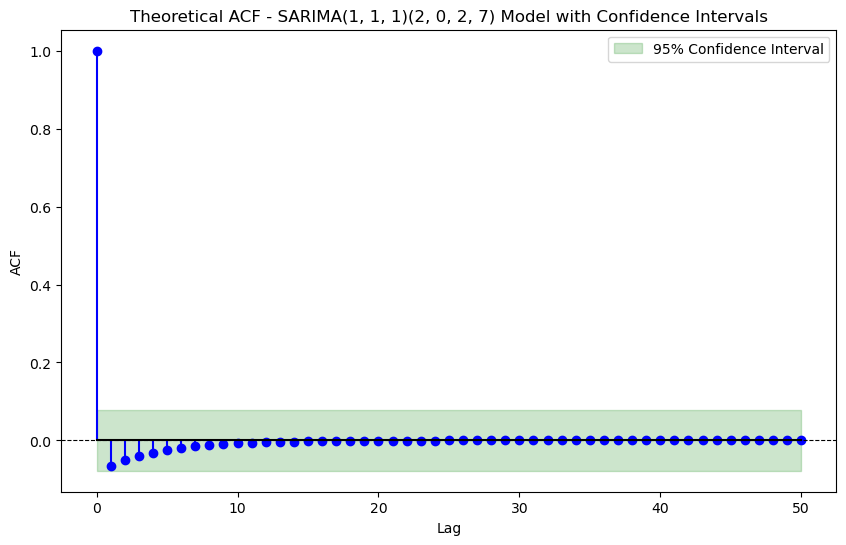

In [138]:
differenced_series = train_series.diff().dropna()  

adf_test = adfuller(differenced_series)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The series is stationary after differencing.")
else:
    print("The series is still non-stationary.")

print("Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the differenced dataset...")
model = SARIMAX(
    differenced_series,
    order=(1, 0, 1),  
    seasonal_order=(2, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(model.summary())

ar_params = model.arparams
ma_params = model.maparams
arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])

n_lags = 50 
theoretical_acf = arma_process.acf(lags=n_lags + 1)

n_samples = len(differenced_series)
conf_interval = 2 / np.sqrt(n_samples)

plt.figure(figsize=(10, 6))
plt.stem(range(n_lags + 1), theoretical_acf, linefmt='b-', basefmt='k', markerfmt='bo', use_line_collection=True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(
    range(n_lags + 1), 
    -conf_interval, 
    conf_interval, 
    color='green', alpha=0.2, label="95% Confidence Interval"
)
plt.title("Theoretical ACF - SARIMA(1, 1, 1)(2, 0, 2, 7) Model with Confidence Intervals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()


**SARIMAX**
 - Add yearly variation into SARIMA models via Fourier Transform

Adding Fourier terms for yearly trends...
Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model with Fourier terms for yearly trends...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Forecasting...
Evaluation Metrics:
  MAPE: 1.1128
  RMSE: 0.0075


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:545: UserWarning:Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


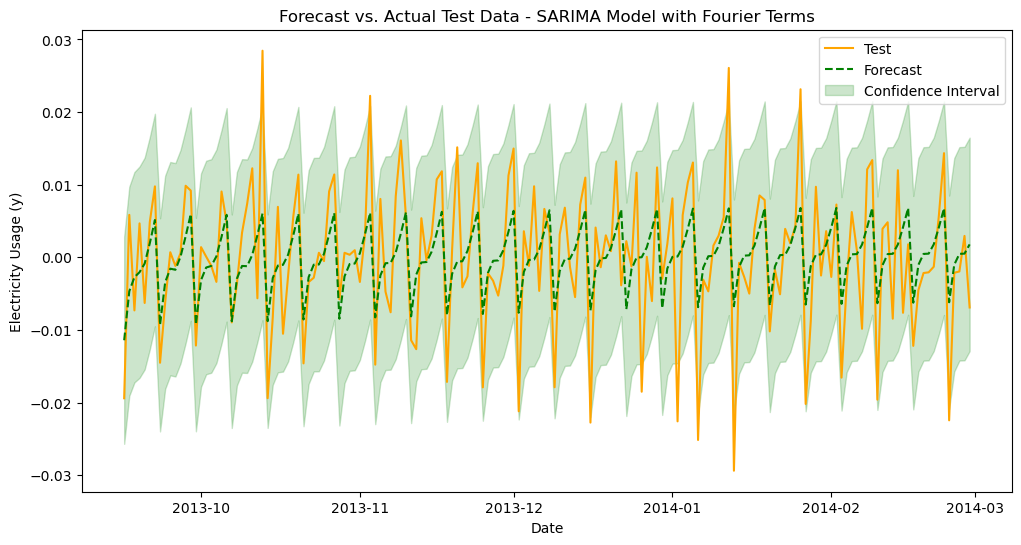

In [ ]:
from statsmodels.tsa.deterministic import Fourier

train_data_daily_differenced = train_data_daily_differenced.set_index('date')
test_data_daily_differenced = test_data_daily_differenced.set_index('date')

print("Adding Fourier terms for yearly trends...")
fourier_yearly = Fourier(period=365.25, order=1)
fourier_terms = fourier_yearly.in_sample(index=train_data_daily_differenced.index)

print("Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model with Fourier terms for yearly trends...")
endog = train_data_daily_differenced['y']
fourier_terms.index = endog.index

model = SARIMAX(
    endog=endog,
    exog=fourier_terms,
    order=(1, 0, 1),
    seasonal_order=(2, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit(disp=False)

print("Forecasting...")
future_fourier_terms = fourier_yearly.out_of_sample(steps=len(test_data_daily_differenced), index=test_data_daily_differenced.index)
forecast_values = results.get_forecast(steps=len(test_data_daily_differenced), exog=future_fourier_terms).predicted_mean
conf_int = results.get_forecast(steps=len(test_data_daily_differenced), exog=future_fourier_terms).conf_int()

test_series = test_data_daily_differenced['y']
mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - SARIMA Model with Fourier Terms")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()


**Gaussian Processes**
- Explore model fit on training data
- Evaluate how well the model performs on unseen data

 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:513: RuntimeWarning:divide by zero encountered in true_divide
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:513: RuntimeWarning:invalid value encountered in true_divide
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:526: RuntimeWarning:invalid value encountered in multiply


Mean Squared Error (MSE): 0.0000
Mean Absolute Percentage Error (MAPE): 1.32%


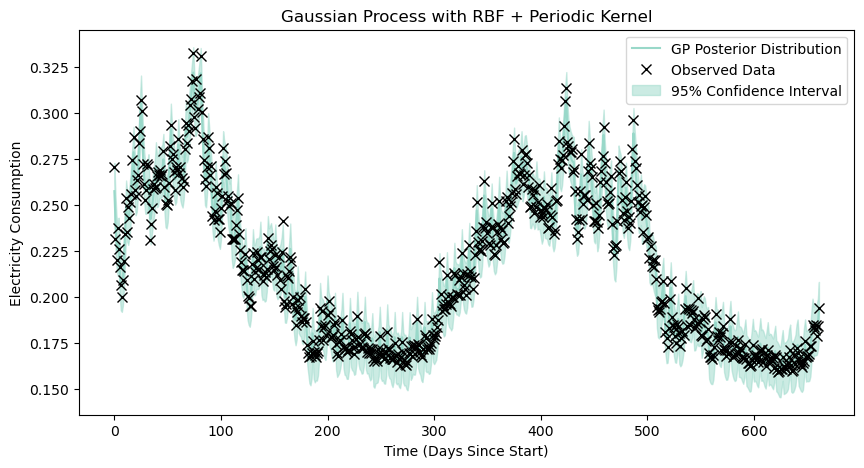

In [95]:
import GPy

train_series.index = pd.to_datetime(train_series.index)
X = (train_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y = np.array(train_series).reshape(-1, 1)

y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

# k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10)
# k_periodic = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=10, period=7)
# k_periodic2 = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=50, period=365)
# kernel = k_rbf + k_periodic * k_periodic2

k_rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=50.0)
k_periodic = GPy.kern.StdPeriodic(input_dim=1, variance=0.7, lengthscale=20.0, period=7)
k_periodic2 = GPy.kern.StdPeriodic(input_dim=1, variance=0.7, lengthscale=30.0, period=365)
kernel = k_rbf + k_periodic + k_periodic2

model = GPy.models.GPRegression(X, y_normalized, kernel)
model.optimize(messages=True, max_iters=300)

y_pred_mean, y_var = model.predict(X)
y_pred_mean = y_pred_mean * y_std + y_mean
y_pred_std = np.sqrt(y_var) * y_std

mse = mean_squared_error(y, y_pred_mean)
mape = mean_absolute_percentage_error(y, y_pred_mean)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

plt.figure(figsize=(10, 5))
plt.plot(X, y_pred_mean, color='#99d8c9', label='GP Posterior Distribution')
plt.plot(X, y, 'x', color='k', label='Observed Data', markersize=7)
plt.fill_between(
    X.flatten(),
    (y_pred_mean - 2 * y_pred_std).flatten(),
    (y_pred_mean + 2 * y_pred_std).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Time (Days Since Start)')
plt.ylabel('Electricity Consumption')
plt.title('Gaussian Process with RBF + Periodic Kernel')
plt.show()

Test Mean Squared Error (MSE): 0.0002
Test Mean Absolute Percentage Error (MAPE): 5.86%


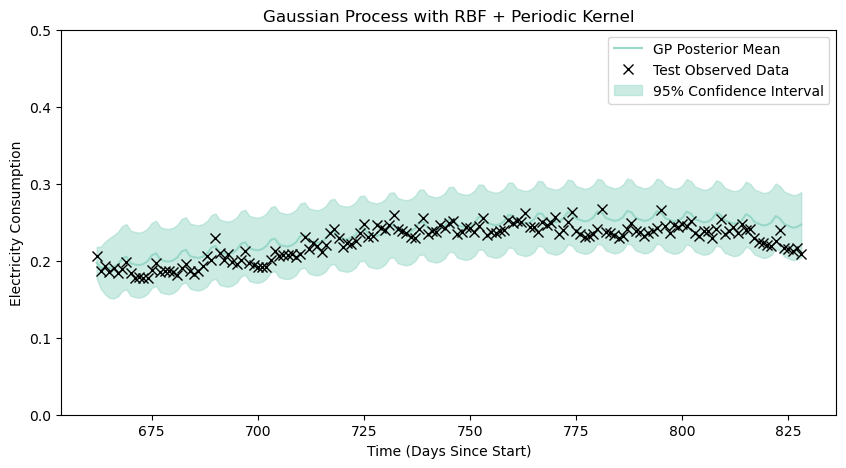

In [96]:
test_series.index = pd.to_datetime(test_series.index)
X_test = (test_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y_test = np.array(test_series).reshape(-1, 1)

y_pred_test, y_var_test = model.predict(X_test)
y_pred_test = y_pred_test * y_std + y_mean
y_std_test = np.sqrt(y_var_test) * y_std

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Test Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape_test:.2%}")

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_pred_test, color='#99d8c9', label='GP Posterior Mean')
plt.plot(X_test, y_test, 'x', color='k', label='Test Observed Data', markersize=7)
plt.fill_between(
    X_test.flatten(),
    (y_pred_test - 2 * y_std_test).flatten(),
    (y_pred_test + 2 * y_std_test).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Time (Days Since Start)')
plt.ylabel('Electricity Consumption')
plt.ylim(0, 0.5)
plt.title('Gaussian Process with RBF + Periodic Kernel')
plt.show()